# Analyze A/B Test Results 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
There are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [5]:
df.query('converted == 1').user_id.nunique()/df.user_id.nunique()

0.12104245244060237

In [6]:
df.query('converted == 1').user_id.nunique()

35173

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [52]:
df.query("group == 'treatment' and landing_page != 'new_page'").shape[0]

1965

**f.** Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  




**a.** Figure out how should I handle the rows where the group and landing_page columns don't match.  Store the new dataframe in **df2**.

In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.query("group=='control' and landing_page=='old_page'").append(df.query("group=='treatment' and landing_page=='new_page'"))

In [10]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  


**a.** How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**c.** Display the rows for the duplicate **user_id**? 

In [13]:
df2.query('user_id=="773192"')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [14]:
# Remove one of the rows with a duplicate user_id..
df2 = df2.drop_duplicates(subset='user_id', keep="first")
# Check again if the row with a duplicate user_id is deleted or not
df2.query('user_id=="773192"')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


### ToDo 1.4  

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>



In [15]:
p_pop = (df2.converted==1).mean()
p_pop

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
cr_old = df2.query("group=='control' and converted==1").shape[0]/df2.query("group == 'control'").shape[0]
cr_old

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
cr_new = df2.query("group=='treatment' and converted==1").shape[0]/df2.query("group == 'treatment'").shape[0]
cr_new

0.11880806551510564

In [18]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = cr_new - cr_old 
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [19]:
(df2.landing_page == 'new_page').mean()

0.50006194422266881

### Conclusion
It seems like there's no practical significance that the new page leads to more conversion as the rates didn't change that much actually by getting `obs_diff` with - 0.0014 indicates that the old page might be more effective than the new one.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, I could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Shall I stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long should I run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, I need to make the decision just based on all the data provided.  

> Recalling that I just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If I assumed that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be my null and alternative hypotheses (**$H_0$** and **$H_1$**)?  


>**My answer will be.**

$$H_0: p_{new} - P_{old} \leq 0$$


$$H_1: P_{new} - P_{old} > 0$$

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assuming that $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, I will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 


**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [20]:
p_new = (df2.converted == 1).mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [21]:
p_old = (df2.converted == 1).mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [22]:
n_new = (df2.query("landing_page=='new_page'").shape[0])
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = (df2.query("landing_page=='old_page'").shape[0])
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>


In [25]:
# Simulate a Sample for the treatment Group
new_page_converted= np.random.binomial(n_new, p_new, 10000)/n_new
p_b_new= new_page_converted.mean()
p_b_new

0.11958747849425368

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [26]:
# Simulate a Sample for the control Group
old_page_converted= np.random.binomial(n_old, p_old, 10000)/n_old 
p_b_old= old_page_converted.mean()
p_b_old

0.11960248564781034

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for my
simulated samples from the parts (e) and (f) above. 

In [29]:
p_b_new - p_b_old

-1.5007153556664821e-05


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [30]:
# Sampling distribution 
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new 
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old 
p_diffs = new_converted_simulation - old_converted_simulation

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.

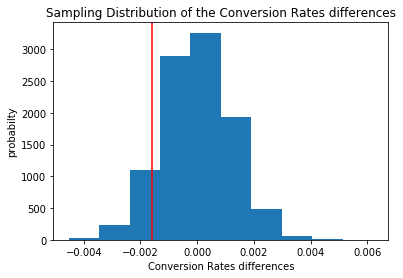

In [31]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff,color='r')
plt.xlabel('Conversion Rates differences')
plt.ylabel('probabilty')
plt.title('Sampling Distribution of the Conversion Rates differences');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [32]:
(np.array(p_diffs)>obs_diff).mean()

0.90769999999999995



**l. Using Built-in Methods for Hypothesis Testing**<br>
I could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [33]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query("landing_page=='old_page' and converted==1").shape[0]

# number of conversions with the new_page
convert_new = df2.query("landing_page=='new_page' and converted==1").shape[0]

# number of individuals who were shown the old_page
n_old = df2.query("landing_page=='old_page'")['converted'].count()

# number of individuals who received new_page
n_new = df2.query("landing_page=='new_page'")['converted'].count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 


In [34]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old], [n_new,n_old], alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


### Conclusion
As this is a right tailed test where the $Z_{score}$ < $Z_{\alpha}$ we fail to reject the null hyposesis that the old page is better than the new page.

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, I will make sure that the result I achieved in the A/B test in Part II above are the same when performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, logistic regression should be performing in this case.

**b.** Use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, I first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [35]:
df2['intercept'] = 1

In [36]:
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [37]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logit_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Providing the summary of the model.

In [38]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-12-21 05:58 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

>**P-value is 0.189, It's diffirent because the regression model checks if the new page affects the conversion it is like two sided test checks if there's no difference in conversion for new and old page. With such a big P-value we get that the new page is not stastically significant in effecting the conversion rate.**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. I will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. I call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 


In [39]:
# Read the countries.csv
df3 = pd.read_csv('countries.csv')
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
# Join with the df2 dataframe
df3=df3.drop_duplicates()
df3.shape


(290584, 2)

In [41]:
df2 = df2.join(df3.set_index('user_id'), on='user_id')

In [42]:
# Create the necessary dummy variables
df2 = df2.join(pd.get_dummies(df2['country']))
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1


In [48]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page','US','UK']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-12-21 06:17 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""


>**While the P-values for the countries and page apear to be higher than 0.05 so we can't say that the countries have an impact on the conversion**

**h. Fitting the model and obtain the results**<br> 
Though I have now looked at the individual factors of country and page on conversion, I would now like to look at an interaction between page and country to see if are there significant effects on conversion.


In [44]:
df2['US_ab'] = df2['ab_page']*df2['US']
df2['UK_ab'] = df2['ab_page']*df2['UK']
df2['CA_ab'] = df2['ab_page']*df2['CA']


In [49]:
# Fit the model, and summarize the results
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page','US','UK','US_ab','UK_ab']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-12-21 06:17 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US_ab          0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
UK_ab          0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

>**By checking the P-value we can see that there's no statistical significace for the new page on convresion**

>**we reject the null hypothesis of the regression model that the new page at variuos contries has an influence on the coversion **

>**That means even in different countries new page has no influence on conversion**

>**This A/B Test suggests that it's better if we keep the old page as it is cause the new page showes no better performance.**